# Peak Shift Analysis
#### Julian Chan
#### Advanced Technology
#### Southern California Edison (SCE)

This Python notebook uses SCE Load and PV Generation data from 2008-2016 to extract and analyze trends in consumer demand as well as the overall load on the SCE system. It also forecasts a shift in the time of day when the SCE system would experience peak load in future years as a result on increasing PV penetration.

The code below:
* Reads the Load and PV Generation data in from "Peak Shift Data.xlsx" and loads it into a Pandas DataFrame
* Extracts the data into Python lists (for plotting)
* Finds the time and day of the year in which the SCE system experienced the highest load (peak load day)
* Plots the data on the peak load day and marks the time when the peak load of that year occurred

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from datetime import datetime, timedelta
from IPython.display import HTML, Image
from scipy.optimize import curve_fit
from matplotlib.pylab import rcParams
from astropy.table import *
import calendar
rcParams['figure.figsize'] = 15, 6

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
load_table = pd.read_excel("Peak Shift Data.xlsx", sheetname="Load Data")

In [4]:
pv_table = pd.read_excel("Peak Shift Data.xlsx", sheetname="PV Data")

In [5]:
load_serial = pd.read_excel("Peak Shift Data.xlsx", sheetname="Serial Load Data", parse_dates=True, index_col="Date and Time")

In [6]:
pv_serial = pd.read_excel("Peak Shift Data.xlsx", sheetname="Serial PV Data", parse_dates=True, index_col="Date and Time")

# ----------------------------------------------------------------------------------------------------------------

## Peak Times for Historical Data: January 1, 2008 - November 30, 2016

In [7]:
def computeYearIndex(year):
    return (year - 2008) % 10

def findPeakLoadDay(year, load):
    """
    INPUT:
        - year: year in which the peak load day will be found
        - load: 2-dimensional array of MW load values in the following format: array[year_index][data_index]
    
    OUTPUT:
        - index of the start of the day (00:00) in which the peak load for the year occurred
    """
    max_index = 0
    max_value = 0
    year_index = computeYearIndex(year)
    for i in range(len(load[year_index])):
        if load[year_index][i] > max_value:
            max_value = load[year_index][i]
            max_index = i
    return (max_index // 24) * 24 - 1

In [8]:
# Find the number of years by assuming the data is formatted in 2 columns each year: date | value
num_years = len(load_table.columns) // 2

# Initialize arrays for storing data
load_dates = [[] for i in range(num_years)]
pv_dates = [[] for i in range(num_years)]

load = [[] for i in range(num_years)]
pv = [[] for i in range(num_years)]

peak_load_dates = []
peak_load = [[] for i in range(num_years)]
peak_pv = [[] for i in range(num_years)]

# Fill 2-dimensional arrays with data (load, PV generation, peak load day data) in the following format: array[year_index][data_index]
for year in range(2008, 2017):
    year_index = computeYearIndex(year)
    load_dates[year_index] = [pd.to_datetime(load_table.at[j, "Date and Time " + str(year)]) for j in range(8040)]
    pv_dates[year_index] = [pd.to_datetime(pv_table.at[4*j, "Date and Time " + str(year)]) for j in range(8040)]
    load[year_index] = [load_table.at[j, "MW " + str(year)] for j in range(8040)]
    pv[year_index] = [np.max([pv_table.at[4*j, "Solar Gen " + str(year)], pv_table.at[4*j + 1, "Solar Gen " + str(year)], pv_table.at[4*j + 2, "Solar Gen " + str(year)], pv_table.at[4*j + 3, "Solar Gen " + str(year)]]) for j in range(8040)]
    
    # Find the index of the start of the peak load day
    peak_load_day_index = findPeakLoadDay(year, load)
    # Record the date of the peak load day
    peak_load_dates.append(load_dates[year_index][peak_load_day_index])
    # Store the peak load day's data
    peak_load[year_index] = load[year_index][peak_load_day_index: peak_load_day_index + 24]
    # Store the peak load day's PV generation
    peak_pv[year_index] = pv[year_index][peak_load_day_index: peak_load_day_index + 24]

Peak for 2008 is at 2008-06-20 16:00:00
Peak for 2009 is at 2009-09-03 16:00:00
Peak for 2010 is at 2010-09-27 15:00:00
Peak for 2011 is at 2011-09-07 16:00:00
Peak for 2012 is at 2012-08-13 15:00:00
Peak for 2013 is at 2013-09-05 16:00:00
Peak for 2014 is at 2014-09-15 15:00:00
Peak for 2015 is at 2015-09-08 16:00:00
Peak for 2016 is at 2016-06-20 16:00:00


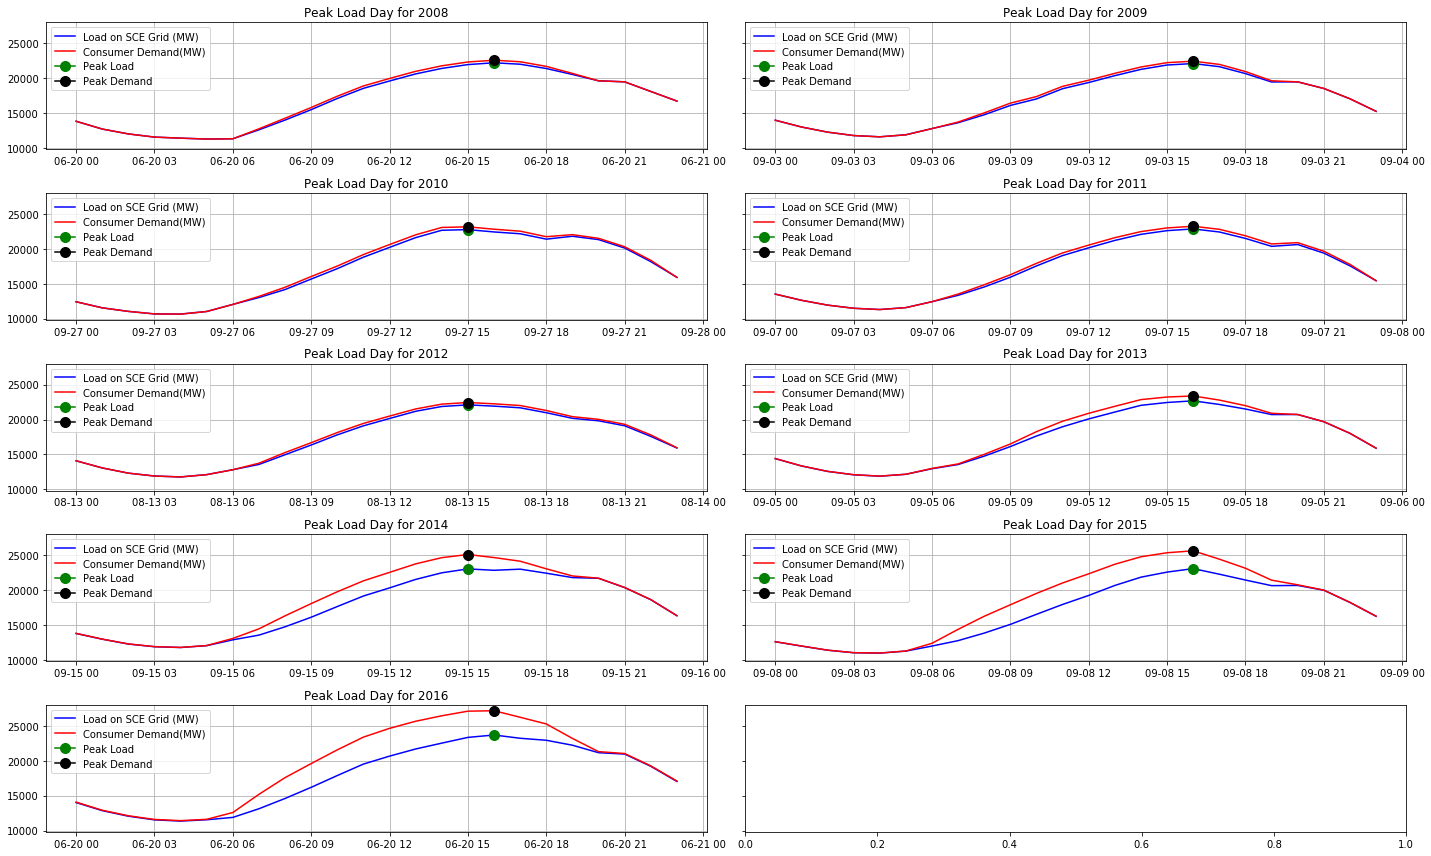

In [9]:
fig, ax = plt.subplots(5, 2, sharey = True, figsize=(20, 12))
for year in range(2008, 2017):
    year_index = computeYearIndex(year)
    time_of_day = [peak_load_dates[year_index] + timedelta(hours=hour) for hour in range(24)]
    
    # Plot the net load
    ax[year_index // 2][year_index % 2].plot(time_of_day, peak_load[year_index], 'b', label="Load on SCE Grid (MW)")
    
    # Plot the actual load (factoring in PV Generation on the peak day)
    pv_on_peak_load_day = pv[year_index][peak_load_day_index: peak_load_day_index + 24]
    actual_demand = [pv_on_peak_load_day[i] + peak_load[year_index][i] for i in range(24)]
    ax[year_index // 2][year_index % 2].plot(time_of_day, actual_demand, 'r', label="Consumer Demand(MW)")
    
    # Plot the peak time and load of the peak load day
    max_index = peak_load[year_index].index(max(peak_load[year_index]))
    x = peak_load_dates[year_index] + timedelta(hours=max_index)
    y = max(peak_load[year_index])
    ax[year_index // 2][year_index % 2].plot([x], [y], marker='o', markersize=10, color="g", label="Peak Load")
    
    # Plot the peak time and demand of the peak load day
    max_index = actual_demand.index(max(actual_demand))
    x = peak_load_dates[year_index] + timedelta(hours=max_index)
    y = max(actual_demand)
    ax[year_index // 2][year_index % 2].plot([x], [y], marker='o', markersize=10, color="k", label="Peak Demand")
    
    # Set plot parameters
    ax[year_index // 2][year_index % 2].set_title("Peak Load Day for " + str(year))
    ax[year_index // 2][year_index % 2].grid(True)
    ax[year_index // 2][year_index % 2].legend(loc="upper left")
    print("Peak for " + str(year) + " is at " + str(x))

fig.tight_layout()

# ----------------------------------------------------------------------------------------------------------------
## Breakdown of Peak Times of Historical Data: January 1, 2008 - November 30, 2016

In [10]:
datetimes = load_serial.axes[0]
temp = load_serial.values
serial_load = [temp[i][0] for i in range(len(temp))]

peakTimesGeneral = []
peakTimesByYear = {2000 + i: [] for i in range(8, 17)}
peakTimesByMonth = {i: [] for i in range(1, 13)}
peakTimesByDay = {"Weekday": [], "Weekend": []}

peakTimesByMonth2015 = {i: [] for i in range(1, 13)} # For the monthly report for 2015
peakTimesByMonth2016 = {i: [] for i in range(1, 13)} # For the monthly report for 2016

i = 0

while i < len(serial_load):
    current_year = datetimes[i].year
    current_month = datetimes[i].month
    day_number = datetimes[i].weekday() # 0 = Monday, 6 = Sunday
    peak_time = np.argmax(serial_load[i: i + 24])

    peakTimesGeneral.append(peak_time)
    peakTimesByYear[current_year].append(peak_time)
    peakTimesByMonth[current_month].append(peak_time)
    
    if day_number < 5:
        peakTimesByDay["Weekday"].append(peak_time)
    else:
        peakTimesByDay["Weekend"].append(peak_time)
        
    # Monthly Report for 2015 and 2016
    if current_year == 2015:
        peakTimesByMonth2015[current_month].append(peak_time)
    elif current_year == 2016:
        peakTimesByMonth2016[current_month].append(peak_time)
    
    i += 24

### General Distribution 2008 - 2016

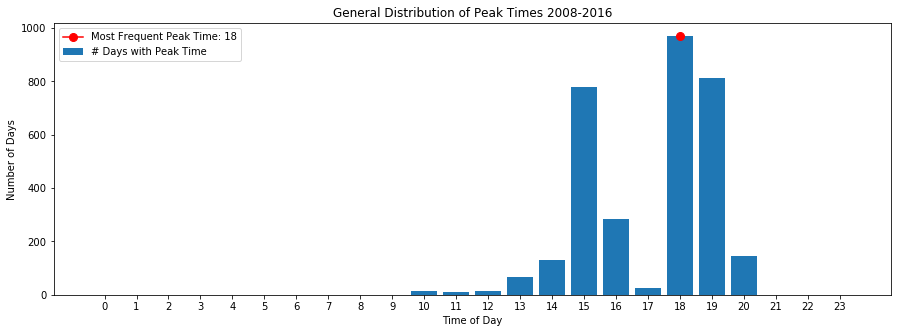

In [11]:
x = [i for i in range(24)]
y = [0 for _ in range(24)]
for time in peakTimesGeneral:
    y[time] += 1
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(x, y, label='# Days with Peak Time')
ax.set_title("General Distribution of Peak Times 2008-2016")
ax.set_xlabel("Time of Day")
ax.set_xticks(x)
ax.set_ylabel("Number of Days")

max_index = np.argmax(y)
max_value = max(y)
ax.plot([max_index], max_value, marker='o', markersize=8, color='r', label='Most Frequent Peak Time: ' + str(max_index).zfill(2))
ax.legend(loc='upper left')

# print("General Distribution of Peak Times 2008-2016:\n")
# x_formatted = tuple(x)
# y_formatted = [tuple(y)]
# t = Table(rows=y_formatted, names=x_formatted)
# t.pprint(show_name = True, max_width = -1, align='^')

### Distribution Breakdown by Year

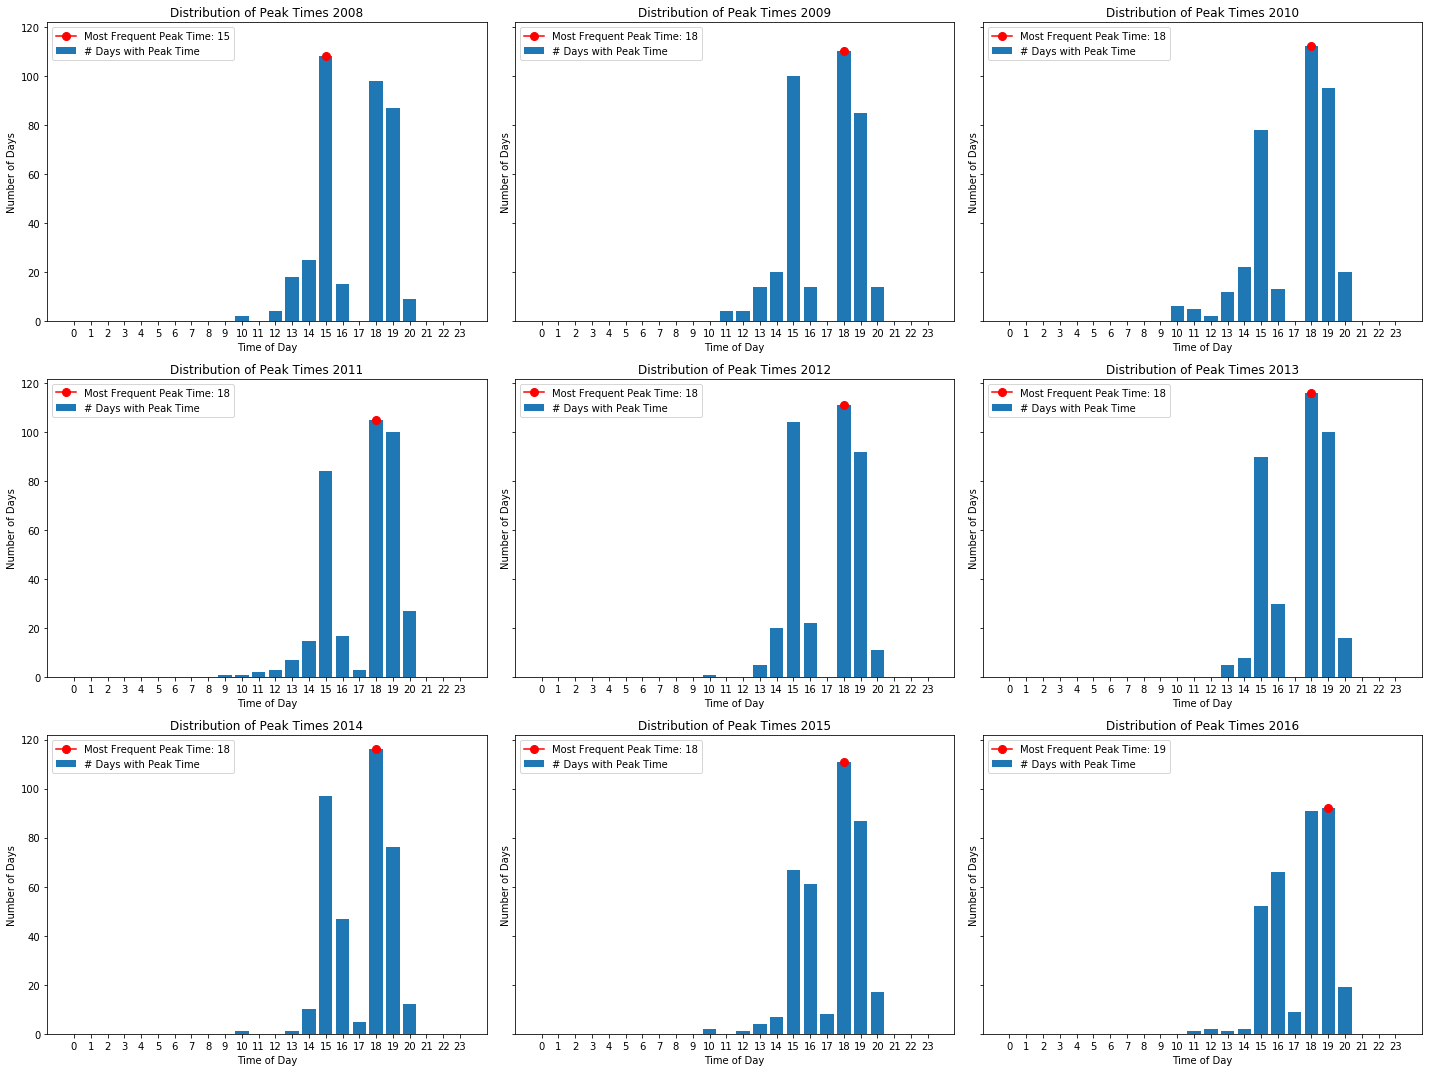

In [12]:
years = list(peakTimesByYear.keys())
peak_times_years = list(peakTimesByYear.values())

fig, ax = plt.subplots(3, 3, sharey=True, figsize=(20, 15))
for i in range(len(years)):
    y = [0 for _ in range(24)]
    for time in peak_times_years[i]:
        y[time] += 1
    ax[i // 3][i % 3].bar(x, y, label='# Days with Peak Time')
    ax[i // 3][i % 3].set_title("Distribution of Peak Times " + str(years[i]))
    ax[i // 3][i % 3].set_xlabel("Time of Day")
    ax[i // 3][i % 3].set_xticks(x)
    ax[i // 3][i % 3].set_ylabel("Number of Days")
    max_index = np.argmax(y)
    max_value = max(y)
    ax[i // 3][i % 3].plot([max_index], max_value, marker='o', markersize=8, color='r', label='Most Frequent Peak Time: ' + str(max_index).zfill(2))
    ax[i // 3][i % 3].legend(loc='upper left')
    
#     print("\nDistribution of Peak Times " + str(years[i]) + ":\n")
#     x_formatted = tuple(x)
#     y_formatted = [tuple(y)]
#     t = Table(rows=y_formatted, names=x_formatted)
#     t.pprint(show_name = True, max_width = -1, align='^')

fig.tight_layout()

### Distribution Breakdown by Month

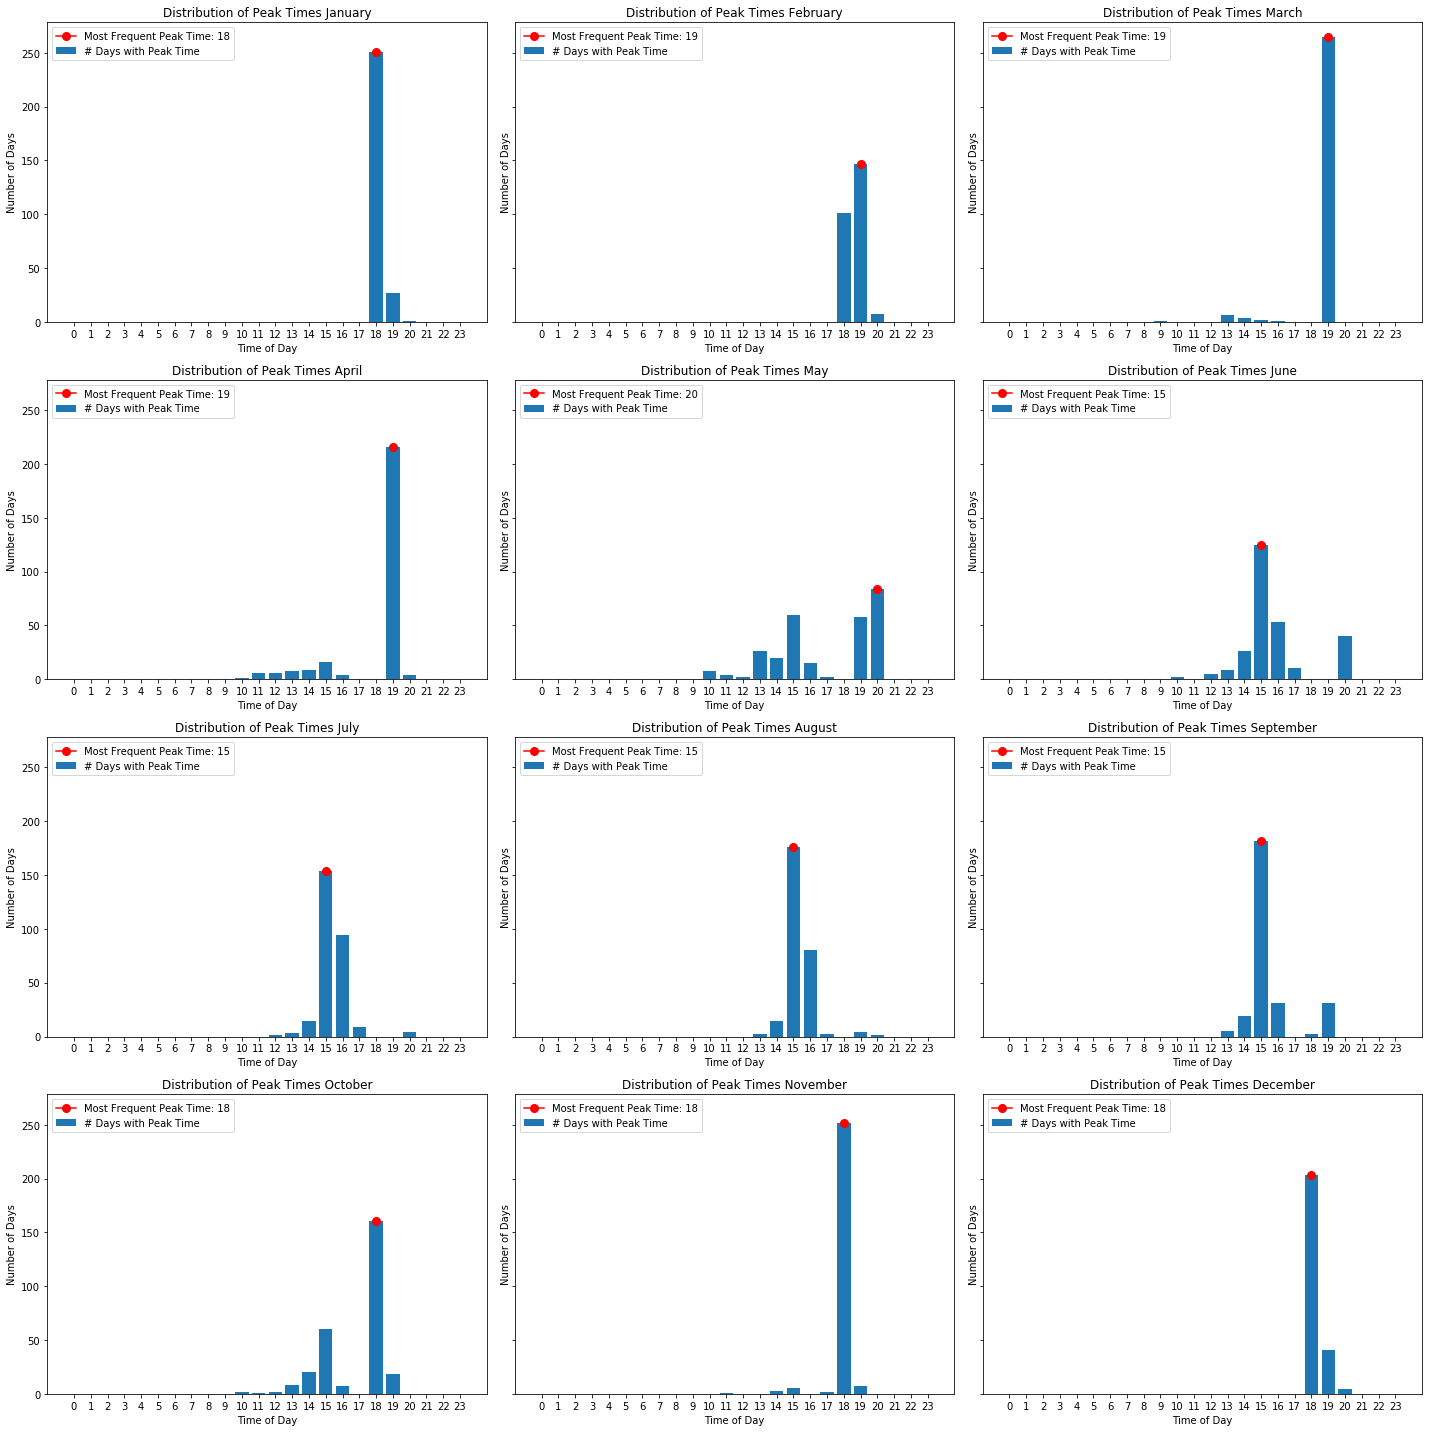

In [13]:
months = list(peakTimesByMonth.keys())
peak_times_months = list(peakTimesByMonth.values())

fig, ax = plt.subplots(4, 3, sharey=True, figsize=(20, 20))
for i in range(len(months)):
    y = [0 for _ in range(24)]
    for time in peak_times_months[i]:
        y[time] += 1
    ax[i // 3][i % 3].bar(x, y, label='# Days with Peak Time')
    ax[i // 3][i % 3].set_title("Distribution of Peak Times " + calendar.month_name[i + 1])
    ax[i // 3][i % 3].set_xlabel("Time of Day")
    ax[i // 3][i % 3].set_xticks(x)
    ax[i // 3][i % 3].set_ylabel("Number of Days")
    max_index = np.argmax(y)
    max_value = max(y)
    ax[i // 3][i % 3].plot([max_index], max_value, marker='o', markersize=8, color='r', label='Most Frequent Peak Time: ' + str(max_index).zfill(2))
    ax[i // 3][i % 3].legend(loc='upper left')
    
#     print("\nDistribution of Peak Times " + calendar.month_name[i + 1] + ":\n")
#     x_formatted = tuple(x)
#     y_formatted = [tuple(y)]
#     t = Table(rows=y_formatted, names=x_formatted)
#     t.pprint(show_name = True, max_width = -1, align='^')

fig.tight_layout()

### Distribution Breakdown by Weekday/Weekend

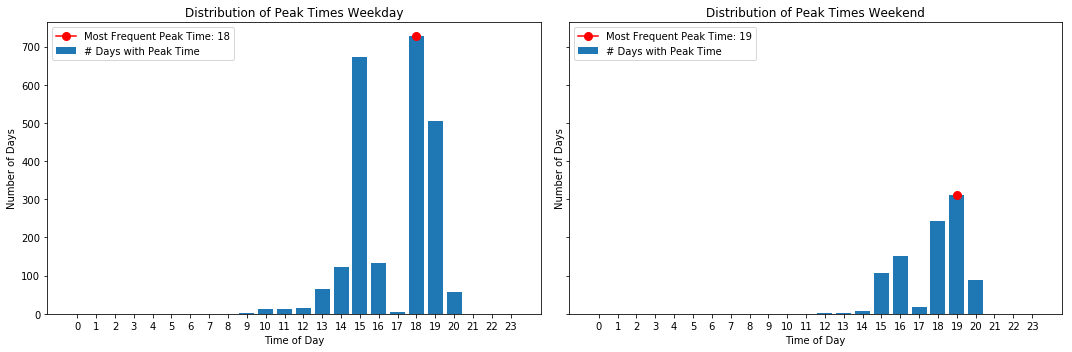

In [14]:
day_types = list(peakTimesByDay.keys())
peak_times_days = list(peakTimesByDay.values())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
for i in range(len(day_types)):
    y = [0 for _ in range(24)]
    for time in peak_times_days[i]:
        y[time] += 1
    ax[i].bar(x, y, label='# Days with Peak Time')
    ax[i].set_title("Distribution of Peak Times " + day_types[i])
    ax[i].set_xlabel("Time of Day")
    ax[i].set_xticks(x)
    ax[i].set_ylabel("Number of Days")
    max_index = np.argmax(y)
    max_value = max(y)
    ax[i].plot([max_index], max_value, marker='o', markersize=8, color='r', label='Most Frequent Peak Time: ' + str(max_index).zfill(2))
    ax[i].legend(loc='upper left')
    
#     print("\nDistribution of Peak Times " + day_types[i] + ":\n")
#     x_formatted = tuple(x)
#     y_formatted = [tuple(y)]
#     t = Table(rows=y_formatted, names=x_formatted)
#     t.pprint(show_name = True, max_width = -1, align='^')

fig.tight_layout()

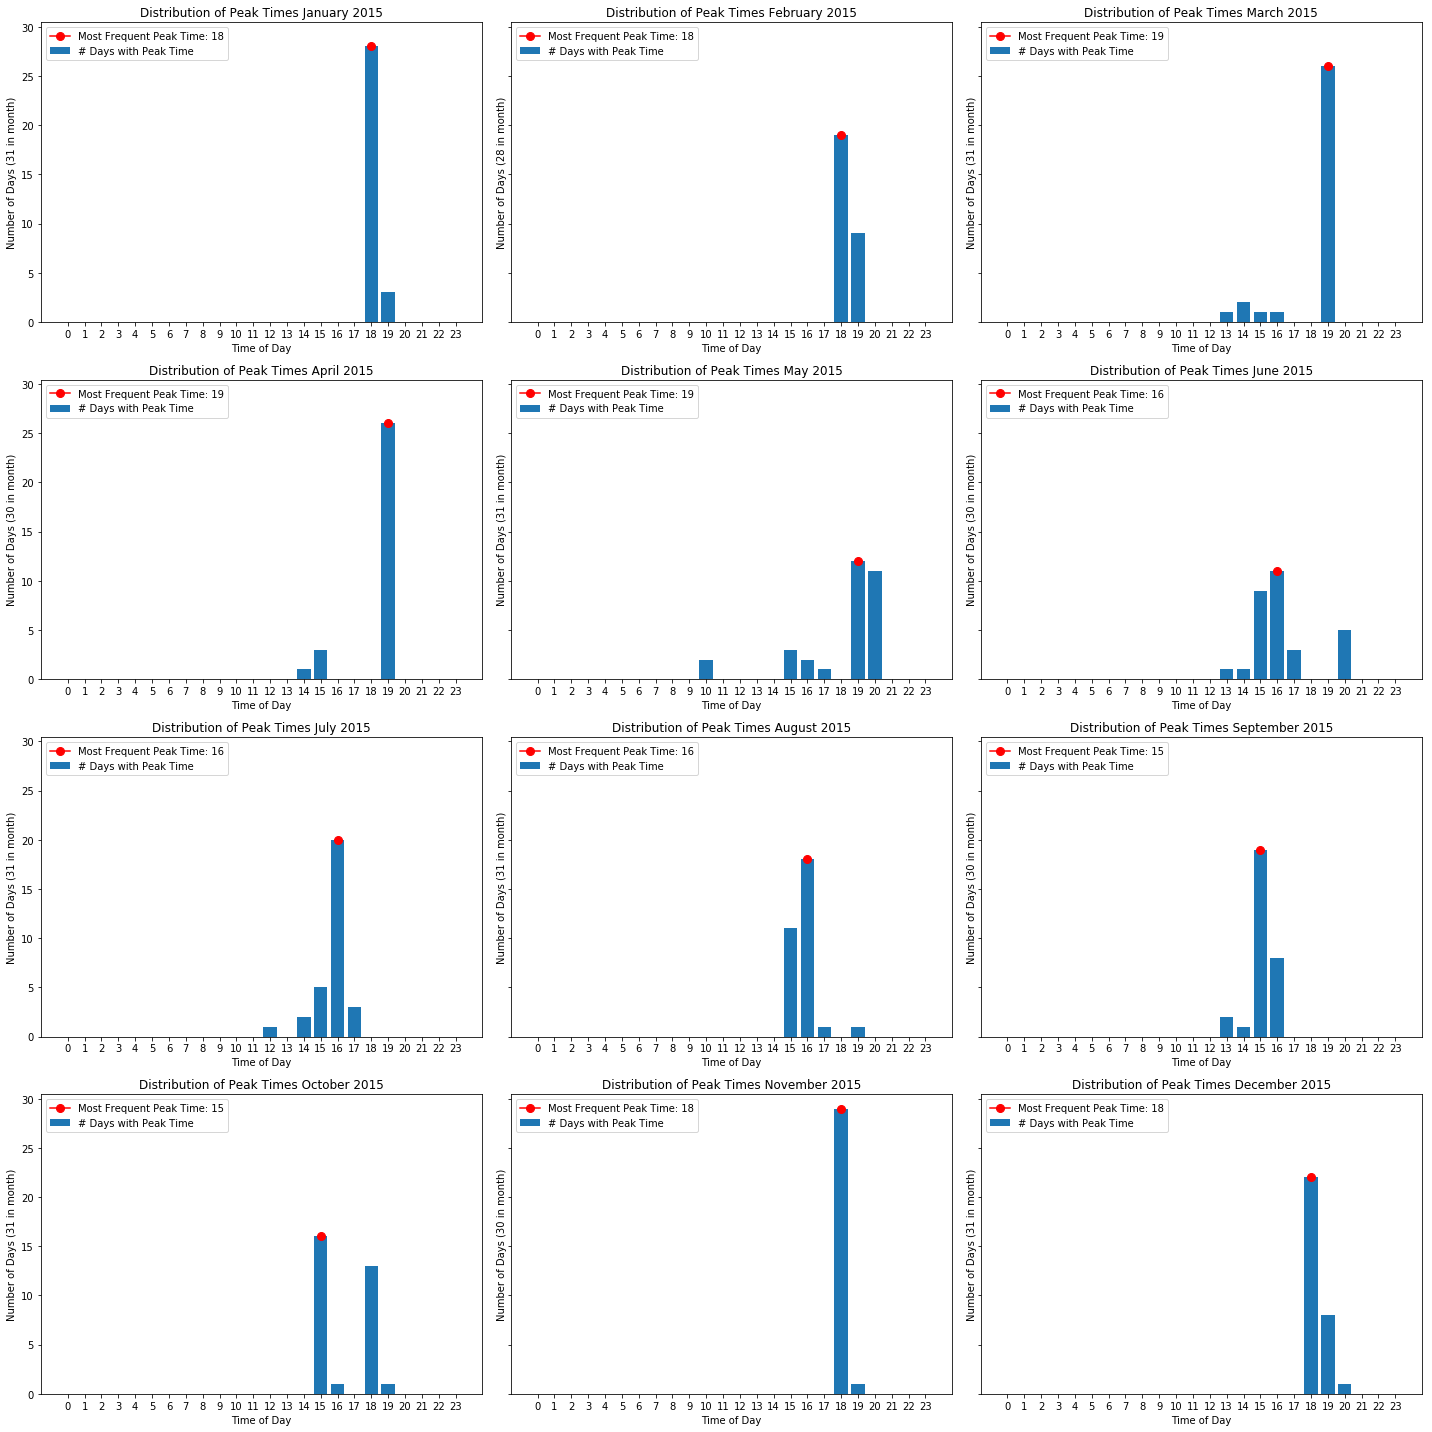

In [15]:
months2015 = list(peakTimesByMonth2015.keys())
peak_times_months2015 = list(peakTimesByMonth2015.values())

fig, ax = plt.subplots(4, 3, sharey=True, figsize=(20, 20))
for i in range(len(months2015)):
    y = [0 for _ in range(24)]
    for time in peak_times_months2015[i]:
        y[time] += 1
    ax[i // 3][i % 3].bar(x, y, label='# Days with Peak Time')
    ax[i // 3][i % 3].set_title("Distribution of Peak Times " + calendar.month_name[i + 1] + " 2015")
    ax[i // 3][i % 3].set_xlabel("Time of Day")
    ax[i // 3][i % 3].set_xticks(x)
    ax[i // 3][i % 3].set_ylabel("Number of Days (" + str(len(peak_times_months2015[i])) + " in month)")
    max_index = np.argmax(y)
    max_value = max(y)
    ax[i // 3][i % 3].plot([max_index], max_value, marker='o', markersize=8, color='r', label='Most Frequent Peak Time: ' + str(max_index).zfill(2))
    ax[i // 3][i % 3].legend(loc='upper left')
    
#     print("\nDistribution of Peak Times " + calendar.month_name[i + 1] + " 2015" + ":\n")
#     x_formatted = tuple(x)
#     y_formatted = [tuple(y)]
#     t = Table(rows=y_formatted, names=x_formatted)
#     t.pprint(show_name = True, max_width = -1, align='^')

fig.tight_layout()

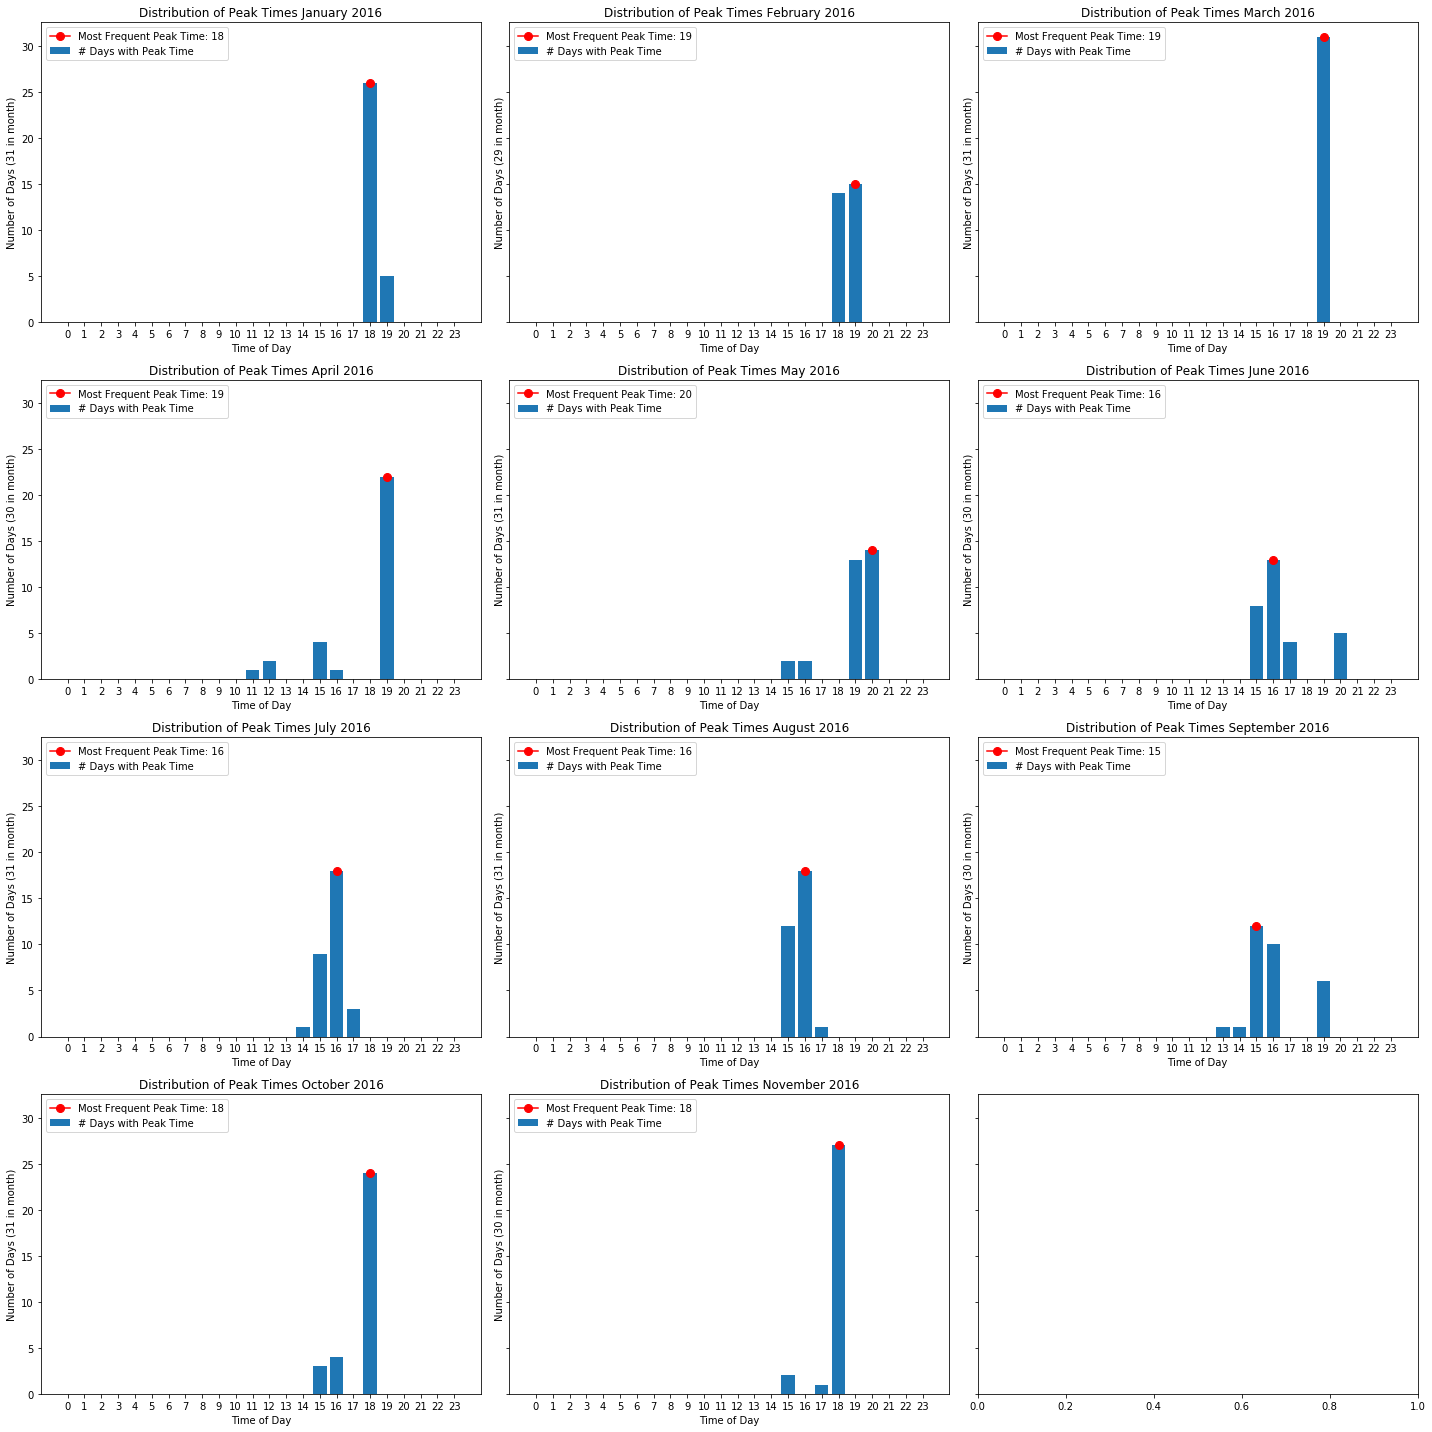

In [16]:
months2016 = list(peakTimesByMonth2016.keys())
peak_times_months2016 = list(peakTimesByMonth2016.values())

fig, ax = plt.subplots(4, 3, sharey=True, figsize=(20, 20))
for i in range(len(months2016) - 1):
    y = [0 for _ in range(24)]
    for time in peak_times_months2016[i]:
        y[time] += 1
    ax[i // 3][i % 3].bar(x, y, label='# Days with Peak Time')
    ax[i // 3][i % 3].set_title("Distribution of Peak Times " + calendar.month_name[i + 1] + " 2016")
    ax[i // 3][i % 3].set_xlabel("Time of Day")
    ax[i // 3][i % 3].set_xticks(x)
    ax[i // 3][i % 3].set_ylabel("Number of Days (" + str(len(peak_times_months2016[i])) + " in month)")
    max_index = np.argmax(y)
    max_value = max(y)
    ax[i // 3][i % 3].plot([max_index], max_value, marker='o', markersize=8, color='r', label='Most Frequent Peak Time: ' + str(max_index).zfill(2))
    ax[i // 3][i % 3].legend(loc='upper left')
    
#     print("\nDistribution of Peak Times " + calendar.month_name[i + 1] + " 2016" + ":\n")
#     x_formatted = tuple(x)
#     y_formatted = [tuple(y)]
#     t = Table(rows=y_formatted, names=x_formatted)
#     t.pprint(show_name = True, max_width = -1, align='^')

fig.tight_layout()

# ----------------------------------------------------------------------------------------------------------------

## PV Daily Profile
#### Procedure:
1. Group the PV generation by hour throughout the year/season/month:
    * {0: [...pvdata for hour 0...], 1: [...pvdata for hour 1...], ... , 23: [...pvdata for hour 23...]}
2. Take the mean for each hour:
    * {0: mean_for_hour_0, 1: mean_for_hour_1, ... , 23: mean_for_hour_23}
3. Take the max mean of the 24 hours and normalize the rest of the data to that max mean to get percentages

In [17]:
datetimes = pv_serial.axes[0]
temp = pv_serial.values
serial_pv = [temp[i][0] for i in range(len(temp))]

dates_pv = {2000 + i: [] for i in range(8, 17)}
year_pv = {2000 + i: [] for i in range(8, 17)}
for i in range(len(serial_pv)):
    current_year = datetimes[i].year
    pv_value = serial_pv[i]
    dates_pv[current_year].append(datetimes[i])
    year_pv[current_year].append(pv_value)

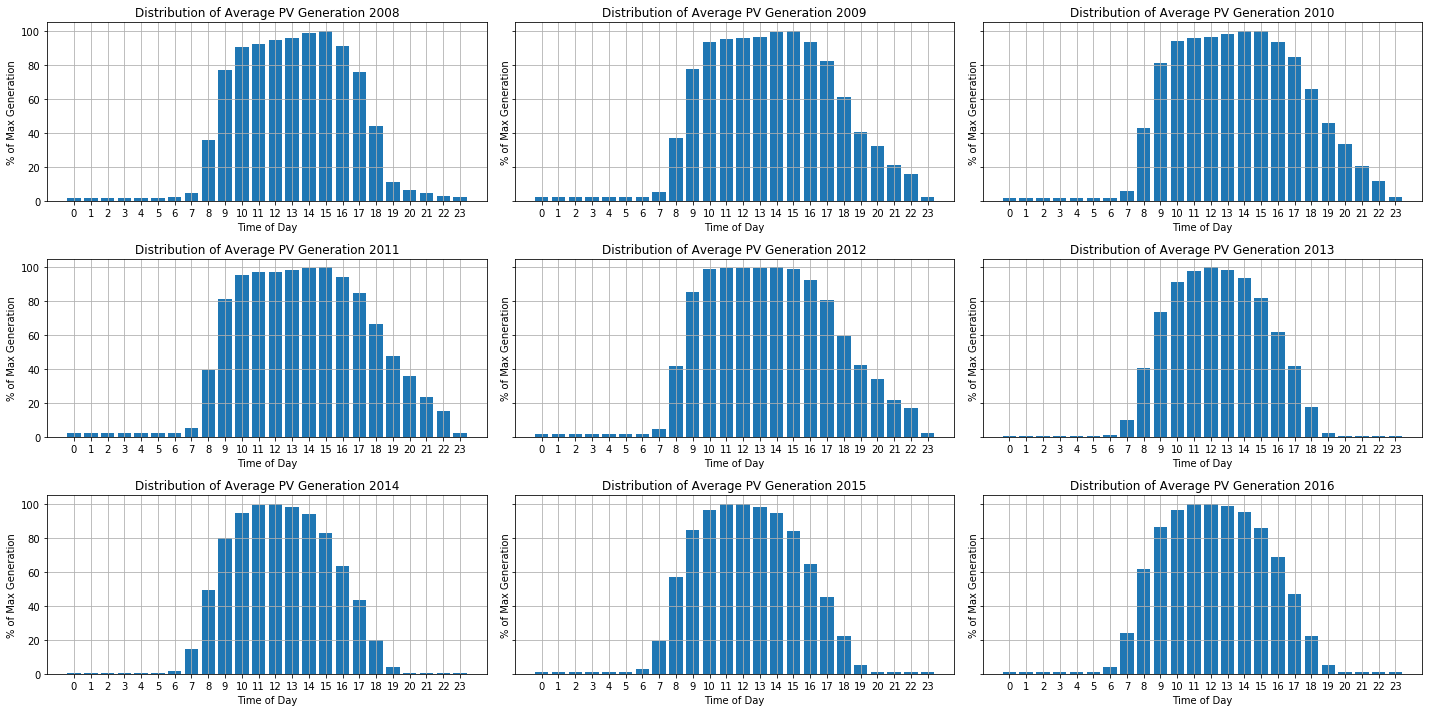

In [18]:
# Transform each data point into a percentage of the max PV generation of each year
year_avg_percent = {2000 + i: [[] for _ in range(24)] for i in range(8, 17)}
for year in year_pv.keys():
    for i in range(len(year_pv[year])):
        current_hour = dates_pv[year][i].hour
        year_avg_percent[year][current_hour].append(year_pv[year][i])
        
for year in year_avg_percent.keys():
    for hour in range(24):
        year_avg_percent[year][hour] = np.mean(np.absolute(year_avg_percent[year][hour]))
        
for year in year_avg_percent.keys():
    max_year_pv = np.max(year_avg_percent[year])
    for hour in range(24):
        year_avg_percent[year][hour] = year_avg_percent[year][hour] / max_year_pv * 100    

x = [i for i in range(24)]
fig, ax = plt.subplots(3, 3, sharey=True, figsize=(20, 10))
for year in year_avg_percent.keys():
    ax[(year - 2008) // 3][(year - 2008) % 3].bar(x, year_avg_percent[year])
    ax[(year - 2008) // 3][(year - 2008) % 3].set_title("Distribution of Average PV Generation " + str(year))
    ax[(year - 2008) // 3][(year - 2008) % 3].set_xlabel("Time of Day")
    ax[(year - 2008) // 3][(year - 2008) % 3].set_xticks(x)
    ax[(year - 2008) // 3][(year - 2008) % 3].set_ylabel("% of Max Generation")
    ax[(year - 2008) // 3][(year - 2008) % 3].grid(True)

fig.tight_layout()

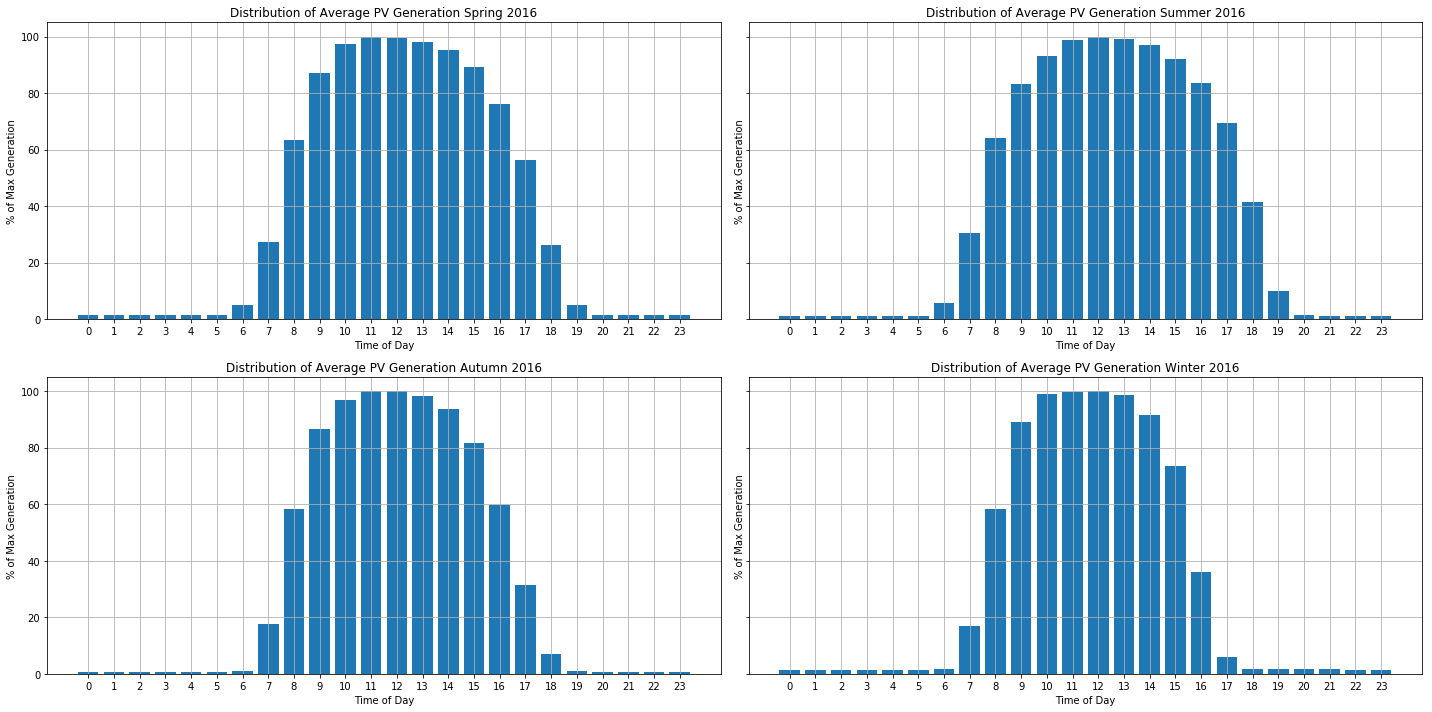

In [19]:
target_year = 2016
target_dates = dates_pv[target_year]
target_pv = year_pv[target_year]

season_dates = {"Spring": [], "Summer": [], "Autumn": [], "Winter": []}
season_pv = {"Spring": [], "Summer": [], "Autumn": [], "Winter": []}

# Separate the data into their respective meteorological seasons
for i in range(len(target_dates)):
    current_date = target_dates[i]
    current_pv = target_pv[i]
    
    if current_date.month in [3, 4, 5]:
        season_dates["Spring"].append(current_date)
        season_pv["Spring"].append(current_pv)
    elif current_date.month in [6, 7, 8]:
        season_dates["Summer"].append(current_date)
        season_pv["Summer"].append(current_pv)
    elif current_date.month in [9, 10, 11]:
        season_dates["Autumn"].append(current_date)
        season_pv["Autumn"].append(current_pv)
    elif current_date.month in [12, 1, 2]:
        season_dates["Winter"].append(current_date)
        season_pv["Winter"].append(current_pv)

# Transform each data point into a percentage of the max PV generation of each season in the target year
season_avg_percent = {"Spring": [[] for _ in range(24)], "Summer": [[] for _ in range(24)], "Autumn": [[] for _ in range(24)], "Winter": [[] for _ in range(24)]}
for season in season_dates.keys():
    for i in range(len(season_dates[season])):
        current_hour = season_dates[season][i].hour
        season_avg_percent[season][current_hour].append(season_pv[season][i])

for season in season_avg_percent.keys():
    for hour in range(24):
        season_avg_percent[season][hour] = np.mean(np.absolute(season_avg_percent[season][hour]))

for season in season_avg_percent.keys():
    max_season_pv = np.max(season_avg_percent[season])
    for hour in range(24):
        season_avg_percent[season][hour] = season_avg_percent[season][hour] / max_season_pv * 100

x = [i for i in range(24)]
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(20, 10))
index = 0
for season in season_avg_percent.keys():
    ax[index // 2][index % 2].bar(x, season_avg_percent[season])
    ax[index // 2][index % 2].set_title("Distribution of Average PV Generation " + season + " " + str(target_year))
    ax[index // 2][index % 2].set_xlabel("Time of Day")
    ax[index // 2][index % 2].set_xticks(x)
    ax[index // 2][index % 2].set_ylabel("% of Max Generation")
    ax[index // 2][index % 2].grid(True)
    
    index += 1

fig.tight_layout()

C:\Users\chanjc\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\chanjc\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


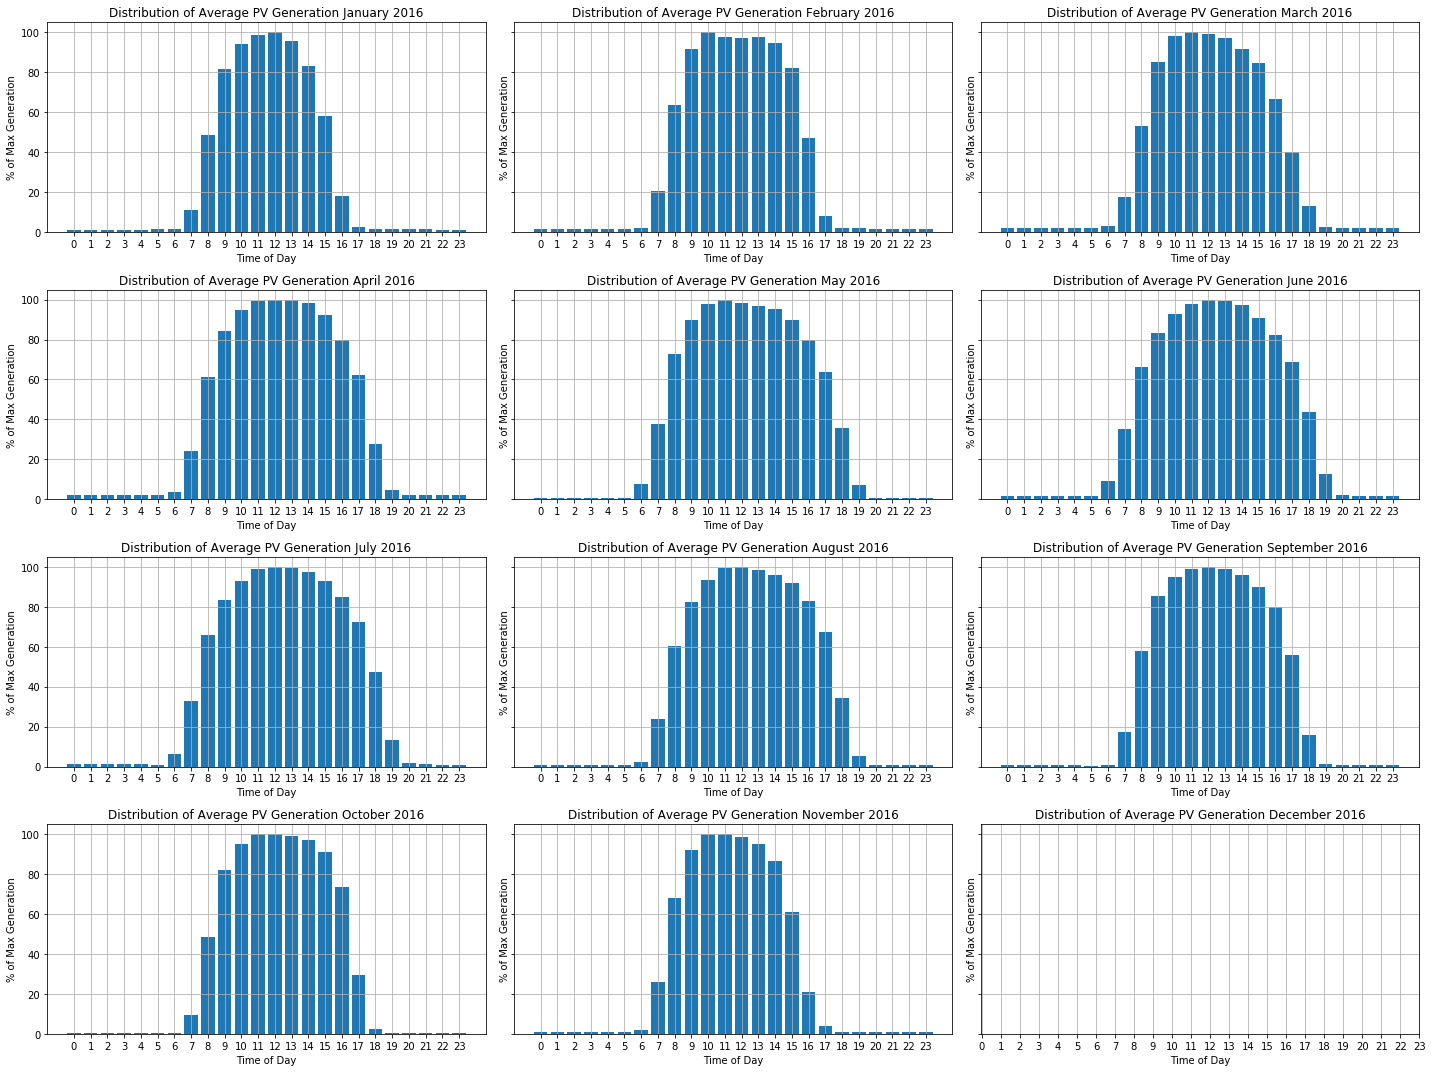

In [20]:
target_year = 2016
target_dates = dates_pv[target_year]
target_pv = year_pv[target_year]

month_dates = {i: [] for i in range(1, 13)}
month_pv = {i: [] for i in range(1, 13)}

# Separate the data into their respective months
for i in range(len(target_dates)):
    current_date = target_dates[i]
    current_month = target_dates[i].month
    current_pv = target_pv[i]
    
    month_dates[current_month].append(current_date)
    month_pv[current_month].append(current_pv)

# Transform each data point into a percentage of the max PV generation of each month in the target year
month_avg_percent = {i: [[] for _ in range(24)] for i in range(1, 13)}
for month in month_dates.keys():
    for i in range(len(month_dates[month])):
        current_hour = month_dates[month][i].hour
        month_avg_percent[month][current_hour].append(month_pv[month][i])

for month in month_avg_percent.keys():
    for hour in range(24):
        month_avg_percent[month][hour] = np.mean(month_avg_percent[month][hour])

for month in month_avg_percent.keys():
    max_month_pv = np.max(month_avg_percent[month])
    for hour in range(24):
        month_avg_percent[month][hour] = month_avg_percent[month][hour] / max_month_pv * 100

x = [i for i in range(24)]
fig, ax = plt.subplots(4, 3, sharey=True, figsize=(20, 15))
for month in month_avg_percent.keys():
    ax[(month - 1) // 3][(month - 1) % 3].bar(x, month_avg_percent[month])
    ax[(month - 1) // 3][(month - 1) % 3].set_title("Distribution of Average PV Generation " + calendar.month_name[month] + " " + str(target_year))
    ax[(month - 1) // 3][(month - 1) % 3].set_xlabel("Time of Day")
    ax[(month - 1) // 3][(month - 1) % 3].set_xticks(x)
    ax[(month - 1) // 3][(month - 1) % 3].set_ylabel("% of Max Generation")
    ax[(month - 1) // 3][(month - 1) % 3].grid(True)

fig.tight_layout()